In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta
import datetime
import statsmodels.api as sm
from scipy.optimize import brute
from itertools import product
from sklearn.metrics import mean_squared_error



# format notebook output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML, Javascript
display(HTML("<style>.container { width:90% !important; }</style>"))

# style pandas display
pd.set_option('display.max_columns', None)

# matplotlib magic
%matplotlib inline

/Users/lee/kaggleVenv/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
air_reserve = pd.read_csv('../../data_files/air_reserve.csv')
air_store_info = pd.read_csv('../../data_files/air_store_info.csv', encoding='utf-8')
air_visit_data = pd.read_csv('../../data_files/air_visit_data.csv')
date_info = pd.read_csv('../../data_files/date_info.csv')
hpg_reserve = pd.read_csv('../../data_files/hpg_reserve.csv')
hpg_store_info = pd.read_csv('../../data_files/hpg_store_info.csv')
sample_submission = pd.read_csv('../../data_files/sample_submission.csv')
store_id_relation = pd.read_csv('../../data_files/store_id_relation.csv')
store_id_relation = pd.read_csv('../../data_files/store_id_relation.csv')
features = pd.read_csv('../../data_files/kaggle_features_sample.csv')

In [32]:
store_data = air_visit_data[air_visit_data['air_store_id']=='air_25e9888d30b386df']
store_data.index = pd.DatetimeIndex(store_data['visit_date'])
store_data['date_id'] = list(map(lambda x:x.strftime('%Y%m%d'),list(store_data.index)))

feature_data = features[features['air_store_id']=='air_25e9888d30b386df']
feature_data.index = pd.DatetimeIndex(feature_data['visit_date'])
feature_data['date_id'] = list(map(lambda x:x.strftime('%Y%m%d'),list(feature_data.index)))

feature_data = feature_data[feature_data['date_id'].isin(list(store_data['date_id']))]

train = store_data.iloc[:-7]
test = store_data.iloc[-7:]
train_features = feature_data[:-7]
test_features = feature_data[-7:]

feature_list = list(features.columns)

/Users/lee/kaggleVenv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/lee/kaggleVenv/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [68]:
from sklearn.metrics import mean_squared_error
data_col = 'visitors'
np.seterr(all='raise')

def build_model(iter_param, series, params_list, static_param=None, exog=None):
  if static_param==None:
    ords = iter_param
    sords = (1,0,0,7)
  else:
    ords = static_param
    sords = iter_param
  try:
    mod = sm.tsa.statespace.SARIMAX(
        series, trend='n', order=ords, seasonal_order=sords,
        exog=exog
      )
    res = mod.fit(disp=0)
    params_list.append(tuple((ords, sords, mean_squared_error(list(series),res.predict()))))
  except:
    params_list.append(tuple((ords, sords, 'NA')))

{'divide': 'raise', 'invalid': 'raise', 'over': 'raise', 'under': 'raise'}

In [72]:
build_results = []
build_model((1,0,0,7),train['visitors'],build_results,(1,1,1))

In [70]:
build_results

[((1, 1, 1), (1, 0, 0, 7), 41.450605311563407)]

In [66]:
mod = sm.tsa.statespace.SARIMAX(
        train['visitors'], trend='n', order=(1,0,0), seasonal_order=(1,0,0,7),
        exog=train_features[[feature_list[5],feature_list[6]]]
      )
res = mod.fit(disp=0)

In [67]:
res.aic

2103.7486104867949

In [105]:
def forward_select(ords, sords, series, exog_df, depth=3):
  exog_list = list(exog_df.columns)
  exog_list.remove('air_store_id')
  exog_list.remove('visit_date')
  exog_list.remove('date_id')
  best_exog = []
  for i in range(depth):
    builds = []
    for exo in exog_list:
      mod = sm.tsa.statespace.SARIMAX(
              series, trend='n', order=ords, seasonal_order=sords,
              exog=exog_df[best_exog+[exo]]
            )
      try:
        res = mod.fit(disp=0)
        builds.append((exo,mean_squared_error(list(series),res.predict())))
      except:
        pass
    best_exog.append(sorted(builds,key=lambda x:x[1])[0][0])
    exog_list.remove(best_exog[-1])
  return best_exog

In [108]:
#best_exog = forward_select((1,0,0),(1,0,0,7),train['visitors'],train_features)
display(best_exog)

['visitors__quantile__q_0.9_wndw_7',
 'visitors__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0_wndw_7',
 'visitors__c3__lag_3_wndw_7']

base_rmse: 57.3484023174
exog_rmse: 57.3484023181


/Users/lee/kaggleVenv/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1924: ValueWarning: Exogenous array provided to predict, but additional data not required. `exog` argument ignored.
  ' required. `exog` argument ignored.', ValueWarning)


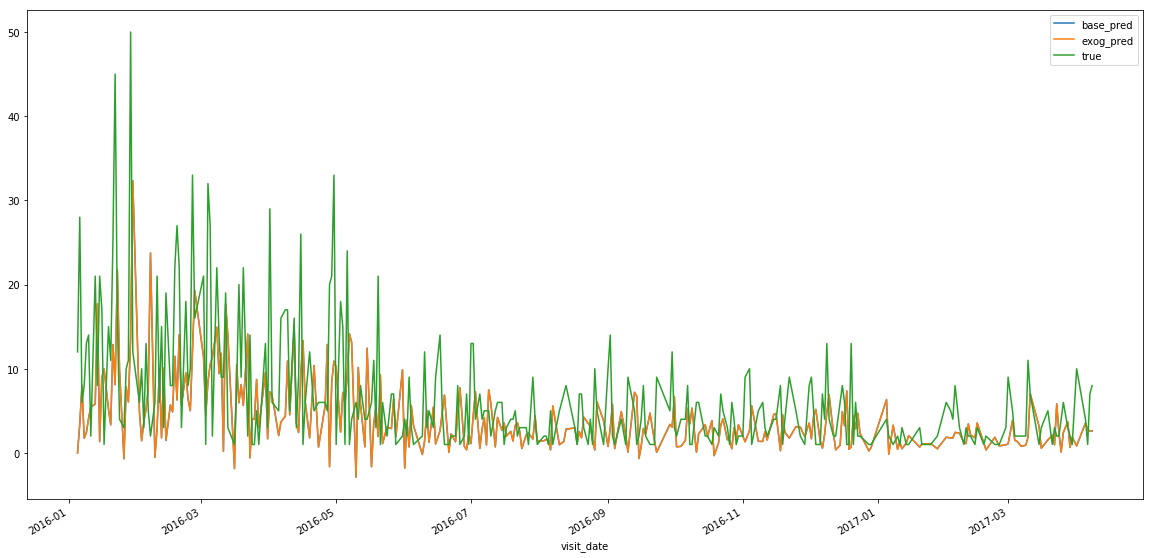

In [115]:
ords=(1,0,0)
sords=(1,0,0,7)
series = train['visitors']
base_mod = sm.tsa.statespace.SARIMAX(series, trend='n', order=ords, seasonal_order=sords)
base_res = base_mod.fit(displ=0)
exog_mod = sm.tsa.statespace.SARIMAX(
        series, trend='n', order=ords, seasonal_order=sords,
        exog=train_features[best_exog]
      )
exog_res = base_mod.fit(disp=0)
results = pd.DataFrame(data={'true':train['visitors'],'base_pred':base_res.predict(),'exog_pred':exog_res.predict(exog=train_features[best_exog])})
print('base_rmse: %s' % mean_squared_error(results['true'],results['base_pred']))
print('exog_rmse: %s' % mean_squared_error(results['true'],results['exog_pred']))
results.plot(figsize=(20,10))